In [2]:
from tweepy import TweepError as twE
import tweepy as tw
import os
import json
import random
from networkx.algorithms.approximation import clique as clq
import networkx as nx
from pyvis.network import Network
import pandas as pd

In [2]:
#Twitter API credentials
api_key = "FzUscQQNsdWhkxebVGFZyuHsh"
api_secret = "Tr1OqulWQIYYI6aEpWVOb7U5NL9DoRtCAviXh4tYg4LXg9sBZe"
access_token = "1040603971637923845-9uZqYh42gsCmwoDCB9nTcoSHrHwiV8"
access_secret = "OsZL0PZC9WDw6Xwcl2ASpIisyfkKW3Bwu4BomNgWxAcj0"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAJQUJQEAAAAA%2B5CTzK8KotMS%2FuB61Dlul7ijBE4%3D5uWZb7w1FPD6nb4SpvmnZ4hxGjqGwzfMquWPHQQooS3jkgNg67"

auth = tw.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, timeout=240)
#attributo timeout indica la durata della connessione

if api.verify_credentials:
    print ('Authentication completed successfully!')

NameError: name 'tw' is not defined

In [15]:
data_folder = "data"

def serialize_json(folder, filename, data):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    with open(f"{folder}/{filename}", 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        f.close()
    print(f"Data serialized to path: {folder}/{filename}")

def read_json(path):
    if os.path.exists(path):
        with open(path, "r", encoding="utf8") as file:
            data = json.load(file)
        print(f"Data read from path: {path}")
        return data
    else:
        print(f"No data found at path: {path}")
        return {}

1. Scaricamento utenti followers ( api.followers ) e utenti following (api.friends ) dei seguenti
    cinque account (i dati numerici potrebbero subire minime variazioni):

    ○ @mizzaro <br>
    ○ @damiano10 <br>
    ○ @Miccighel_ <br>
    ○ @eglu81 <br>
    ○ @KevinRoitero


In [7]:
accounts = ["mizzaro" , "damiano10", "Miccighel_", "eglu81", "KevinRoitero"]
followers = [157, 786, 332, 539, 103]
followings = [331, 837, 212, 621, 256]

accounts --> vettore contenenti gli screen_name dei quali si vogliono scaricare i dati (vettore)<br>
what --> specifica il cosa voglio scaricare (stringa) <br>
quantity --> quantità di followers/followings si vogliono scaricare (intero) <br>
operation --> funzione dell'API da chiamere (funzione)

In [5]:
#download passando vettore di quantità
def download(users, what, quantity, operation):
    i = 0

    for user in users:
        data= []
        print(f"Downloading {what} di {user}")

        for item in tw.Cursor(
            operation,
            screen_name=user,
            skip_status=True,
            include_user_entities=False
        ).items(quantity[i]):

            retriveData(item, data)

        serialize_json(data_folder, f"{user}-{what}s.json", data)
        print(f"ho serializzato un totale di {len(data)} dati \n")
        i += 1

def retriveData(item, data):
    json_data = item._json
    found_follower = {}

    found_follower["id"] = json_data["id"]
    found_follower["name"] = json_data["name"]
    found_follower["screen_name"] = json_data["screen_name"]
    found_follower["location"] = json_data["location"]

    data.append(found_follower)

## Download follower

In [ ]:
download(accounts, "follower", followers, api.followers)
print("Download terminato")

## Download following

In [ ]:
download(accounts, "following", followings, api.friends)
print("Download terminato")

2. Scegliete 5 utenti followers a caso tra quelli di ciascuno dei cinque account e
    scaricate ulteriori 10 utenti followers ( followers dei followers )


In [6]:
def rndIndex(quantity, max):
    rndNum = []

    while len(rndNum) < quantity:
        pos = random.randint(0, max)

        if pos not in rndNum:
            rndNum.append(pos)
    return rndNum

#recupera gli screen_name dei 5 account random
def retriveAccounts(rnd, file):
    data = read_json(f"{data_folder}/{file}")
    newAccounts = []

    for index in rnd:
        #controllo che aaccount selezionato abbia più di 10 followers
        item = data[index]

        if len(api.followers_ids(item["screen_name"])) >= 10 :
            newAccounts.append(item["screen_name"])
            #non gestisce il caso in cui ci siano meno di 10 amici

    return newAccounts

#download con quantity valore intero
def specificQuantityDownload(users, what, quantity, operation):

   for user in users:
        data= []
        print(f"Downloading {what} di {user}")

        for item in tw.Cursor(
            operation,
            screen_name=user,
            skip_status=True,
            include_user_entities=False
        ).items(quantity):

            retriveData(item, data)

        serialize_json(data_folder, f"{user}_{what}s.json", data)
        print(f"ho serializzato un totale di {len(data)} dati \n")

## Download followers of followers

In [ ]:
i = 0
for account in accounts:
    max = followers[i]

    rndNum = rndIndex(5, max)

    specificQuantityDownload(retriveAccounts(rndNum, f"{account}-followers.json"),
                                                f"{account}-followersOfFollower", 10, api.followers)
    i += 1

print("Download terminato")

3. Scegliete 5 utenti following a caso tra quelli di ciascuno dei cinque account e
    scaricate ulteriori 10 utenti following ( following dei following )

## Download followings of followings

In [ ]:
i = 0
for account in accounts:
    max = followings[i]

    rndNum = rndIndex(5, max)

    specificQuantityDownload(retriveAccounts(rndNum, f"{account}-followings.json"),
                                                f"{account}-followingsOfFollowing", 10, api.friends)
    i += 1

print("Download terminato")

4. Scaricare i dettagli del profilo di tutti gli utenti recuperati ( api.get_user )


In [7]:
#si può togliere operation e vedere doc api.get_user
def downloadUserDataFromString(users, output):
    for user in users:
        print(f"Downloading userData di {user}")

        foundUser = api.get_user(user)
        retriveUserData(foundUser, output)

    return output

def downloadUserDataFromObject(users, output):
    for user in users:
        print(f"Downloading userData di {user['screen_name']}")
        try:
            foundUser = api.get_user(user["id"])
            retriveUserData(foundUser, output)
        except twE: #usato per gestire il caso in cui il profilo risulta impossibile da scaricare
            print("User not found!")

    return output

def retriveUserData(item, data):
    json_data = item._json

    profile_data = {}

    profile_data["id"] = json_data["id"]
    profile_data["name"] = json_data["name"]
    profile_data["screen_name"] = json_data["screen_name"]
    profile_data["location"] = json_data["location"]
    profile_data["description"] = json_data["description"]
    profile_data["followers_count"] = json_data["followers_count"]

    if profile_data not in data:
        data.append(profile_data)

## Download info utenti

In [ ]:
lstFile = os.listdir(data_folder)#lista dei file contenuti nella directory "data"

if "usersData.json" not in lstFile:
    userData = []
    #download user data degli uterti di partenza(mizzaro, damiano10,...)
    downloadUserDataFromString(accounts, userData)

    for file in lstFile:
       jsonItems = read_json(f"{data_folder}/{file}")

       downloadUserDataFromObject(jsonItems, userData)

    print(f"ho serializzato un totale di {len(userData)} dati \n")

    serialize_json(data_folder, f"usersData.json", userData)
else:
    print("I dati utente sono già stati serializzati in precedenza")

print("Download terminato")

5. Costruite la rete sociale (grafo):

    ○ Inserite l’ id di ciascun utente come identificatore del nodo <br>
    ○ Ogni arco rappresenta una relazione follows tra due utenti <br>
    ○ La presenza della relazione va verificata tra tutti gli utenti scaricati ed i cinque account iniziali ( api.show_friendship ) <br>
    ○ Inserite i dettagli del profilo di ciascun utente come attributi del nodo <br>
    ○ Inserite i membri del vostro gruppo come attributi del grafo <br>
    ○ Per ogni nodo, aggiungete un attributo con il numero di follower individuati


In [ ]:
#funzione che controlla se gli utenti iniziali con quelli scaricati sono in relazione tra di loro(follower o following)
#Questa funzione non verrà eseguita per motivi di tempo
def checkFriendships(nodes):
    for i in range(5):
        for j in range(len(nodes)):

            if i != j:
                friendship = api.show_friendship(source_id=nodes[i]["id"], target_id= nodes[j]["id"])

                if friendship[0].followed_by:
                    print(f"{nodes[i]['screen_name']} è seguito da {nodes[j]['screen_name']}")
                else:
                    print(f"{nodes[i]['screen_name']} non è seguito da {nodes[j]['screen_name']}")

                if friendship[0].following:
                    print(f"{nodes[i]['screen_name']} segue {nodes[j]['screen_name']}")
                else:
                    print(f"{nodes[i]['screen_name']} non segue {nodes[j]['screen_name']}")

                print("\n")

checkFriendships(read_json(f"{data_folder}/usersData.json"))

In [17]:
def createIdDictionary(lst):
    id = {}
    for item in lst:
        id.update({f"{item['screen_name']}": item["id"]})

    return id

pwd = os.listdir()
lstFile = os.listdir(data_folder)

if "twtNet_graph.pkl" in pwd:
    twtNet = nx.read_gpickle("twtNet_graph.pkl")
    print("Recupero del grafo di twitter")
else:
    nodes = read_json(f"{data_folder}/usersData.json")

    twtNet = nx.DiGraph(group_members= ["Gasparollo Denis", "Francescut Matteo", "Bensi Martino", "Rizzetto Sasha"])
    #aggiunta nodo
    for node in nodes:
        twtNet.add_node(node["id"],
                        name= node["name"],
                        screen_name= node["screen_name"],
                        location= node["location"],
                        description= node["description"],
                        followers_count= node["followers_count"])
    print(nx.number_of_nodes(twtNet))

    #aggiunta archi
    idDictionary = createIdDictionary(nodes)

    for file in lstFile:

        if "usersData" not in file:
            splitedFileName = file.split(sep= "-", maxsplit=3)

            for user in read_json(f"{data_folder}/{file}"):

                if "followings" in splitedFileName[len(splitedFileName) - 1]:
                    twtNet.add_edge(idDictionary[splitedFileName[0]], user["id"])
                elif "followers" in splitedFileName[len(splitedFileName) - 1]:
                    twtNet.add_edge(user["id"], idDictionary[splitedFileName[0]])

    print("Il grafo è stato costruito con successo!")
    nx.write_gpickle(twtNet, "twtNet_graph.pkl")

Data read from path: data/usersData.json
3131
Data read from path: data/ABCFactCheck-damiano10-followingsOfFollowings.json
Data read from path: data/ABH878-mizzaro-followersOfFollowers.json
Data read from path: data/ACMSIGIR-KevinRoitero-followingsOfFollowings.json
Data read from path: data/airamoigroig-mizzaro-followingsOfFollowings.json
Data read from path: data/arjenpdevries-KevinRoitero-followersOfFollowers.json
Data read from path: data/BrachaShapira-damiano10-followingsOfFollowings.json
Data read from path: data/CaRRws-mizzaro-followingsOfFollowings.json
Data read from path: data/CreatoursUK-Miccighel_-followersOfFollowers.json
Data read from path: data/CriMuntean-KevinRoitero-followersOfFollowers.json
Data read from path: data/cs2_school-KevinRoitero-followersOfFollowers.json
Data read from path: data/CSSamsterdam-damiano10-followersOfFollowers.json
Data read from path: data/dailyrando-Miccighel_-followersOfFollowers.json
Data read from path: data/DameWendyDBE-eglu81-followingsO

6. Producete una visualizzazione interattiva del grafo usando pyvis


In [18]:
#modificare parametri per cambiare la parte grafica
net = Network(
    height = "100%",
    width = "100%",
    directed=True,
    bgcolor = "#222222",
    font_color = "white",
    heading = "Rete Sociale"
)

net.barnes_hut()#si possono cambiare parametri
net.from_nx(twtNet)
neighbor_map = net.get_adj_list()

for node in net.nodes:
    node["value"] = len(neighbor_map[node["id"]])

net.show("twtNet.html")

7. Verificate se il grafo:

    ○ è connesso ( is_connected ) <br>
    ○ è bipartito ( is_bipartite )

In [48]:
if "twtNet_graph.pkl" in os.listdir():
    twtNet = nx.read_gpickle("twtNet_graph.pkl")

    if  nx.is_connected(nx.to_undirected(twtNet)):
        print("Il grafo è connesso")
    else:
        print("Il grafo non è connesso")

    if nx.is_bipartite(twtNet):
        print("Il grafo è bipartito")
    else:
        print("Il grafo non è bipartito")
else:
    print("Grafo non ancora creato!")

Il grafo è connesso
Il grafo non è bipartito


8. Misurate le seguenti distanze sul grafo:

    ○ Centro ( center ) <br>
    ○ Diametro ( diameter ) <br>
    ○ Raggio ( radius )


In [7]:
if "twtNet_graph.pkl" in os.listdir():
    twtNet = nx.read_gpickle("twtNet_graph.pkl")

    print(f"Centro: {nx.center(nx.to_undirected(twtNet))}")
    print(f"Diametro: {nx.diameter(nx.to_undirected(twtNet))}")
    print(f"Raggio: {nx.radius(nx.to_undirected(twtNet))}")
else:
    print("Grafo non ancora creato!")

Centro: [132646210, 19659370, 3036907250]
Diametro: 6
Raggio: 3


9. Calcolate le seguenti misure di centralità sul grafo:

    ○ Betweenness centrality ( betweenness_centrality ) <br>
    ○ Closeness centrality ( closeness_centrality ) <br>
    ○ Degree centrality ( degree_centrality ) <br>
    ○ In-degree centrality ( in_degree_centrality ) <br>
    ○ Out-degree centrality ( out_degree_centrality ) <br>
    ○ Page Rank ( pagerank ) <br>
    ○ HITS ( hits )


In [4]:
if "twtNet_graph.pkl" in os.listdir():
    twtNet = nx.read_gpickle("twtNet_graph.pkl")

    betweennessCentrality = nx.betweenness_centrality(twtNet)
    closenessCentrality = nx.closeness_centrality(twtNet)
    degreeCentrality = nx.degree_centrality(twtNet)
    inCentrality = nx.in_degree_centrality(twtNet)
    outCentrality = nx.out_degree_centrality(twtNet)
    pageRank = nx.pagerank(twtNet)
    hits = nx.hits(twtNet, max_iter=150)

    print("Calcolo centralità terminato!")
else:
     print("Grafo non ancora creato!")

Calcolo centralità terminato!


In [8]:
print(f"Betweenness centrality: {betweennessCentrality}")
print(f"Closeness centrality: {closenessCentrality}")
print(f"Degree centrality: {degreeCentrality}")
print(f"IN degree centrality: {inCentrality}")
print(f"OUT degree centrality: {outCentrality}")
print(f"Page rank: {pageRank}")
print(f"HITS hubs: {hits[0]}")
print(f"HITS authorities: {hits[1]}")

Betweenness centrality: {18932422: 0.05367070078074617, 132646210: 0.23978095486139883, 15750573: 0.1124678727295444, 19659370: 0.17358815573320538, 3036907250: 0.04849336889413692, 27131901: 0.0, 1460313109: 0.0, 221575638: 0.0, 188644374: 0.0, 327347231: 0.0, 975496040286531584: 0.0, 1006419421244678144: 0.0, 56077211: 0.0, 39748571: 0.0, 96034010: 0.0, 392531560: 0.0, 2850524162: 0.0, 781805906: 0.0, 1609328383: 0.0, 204965245: 0.0, 1284897085846953986: 0.0, 964072678020837377: 0.0, 484733763: 0.0, 54875928: 2.8959095023178496e-05, 710583925: 0.0, 87889325: 0.0, 4713059201: 0.0, 773146218: 0.0, 111046352: 0.0, 232832623: 0.0, 20660258: 0.0, 247660554: 0.0, 1571112116: 0.0, 1097846996: 0.0, 2334835022: 0.0, 2427366498: 0.0, 97436767: 0.0, 144580542: 0.0, 22346932: 0.0, 955910820642344960: 0.0, 1256240551118200835: 0.0, 388729560: 0.0, 1142819859472048131: 0.0, 1290762290224984064: 0.0, 1605: 0.0, 1141689200099639296: 0.0, 1260526934678740993: 0.0, 1546634102: 0.0, 197957154: 0.0, 220

TypeError: tuple indices must be integers or slices, not str

10. Generate un sottografo del grafo ( ego_graph ) e calcolate:

    ○ Cricca massima ( max_clique ) <br>
    ○ Dimensione della cricca massima ( large_clique_size )

La dimensione del sottografo calcolato sulla cricca massima vale: 7


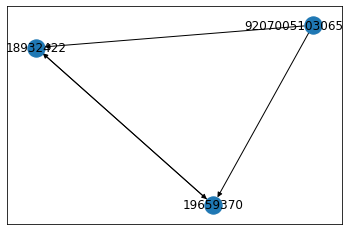

In [9]:
pwd = os.listdir()

if "maxClique_graph.pkl" in pwd:
    cliqueGraph = nx.read_gpickle("maxClique_graph.pkl")
    print("Recupero del grafo che mostra la cricca massima")
else:
    if "twtNet_graph.pkl" in pwd:
        twtNet = nx.read_gpickle("twtNet_graph.pkl")

        roiteroGraph = nx.ego_graph(twtNet, 3036907250, radius=1)
        clique = clq.max_clique(roiteroGraph)
        cliqueGraph = twtNet.subgraph(clique)
        nx.write_gpickle(clique, "maxClique_graph.pkl")
    else:
        print("Grafo non ancora creato!")

nx.draw_networkx(cliqueGraph)
dimensione = nx.number_of_nodes(cliqueGraph) + nx.number_of_edges(cliqueGraph)
print(f"La dimensione del sottografo calcolato sulla cricca massima vale: {dimensione}")

11. Calcolate la copertura minima degli archi ( min_edge_cover ) del grafo


In [60]:
if "twtNet_graph.pkl" in os.listdir():
    twtNet = nx.read_gpickle("twtNet_graph.pkl")

    minCover = nx.min_edge_cover(nx.to_undirected(twtNet))
    print(f"Copertura minima arco: {minCover}")
else:
    print("Grafo non ancora creato!")

nx.draw_networkx()

Copertura minima arco: {(132646210, 18869136), (21782750, 132646210), (15750573, 1023096199), (132646210, 40030538), (19659370, 37788263), (132646210, 1081289442671902720), (19659370, 469405173), (132646210, 72474729), (1323903942951112705, 91168371), (40380303, 15750573), (3036907250, 52059998), (19659370, 2606773789), (132646210, 809848752), (436847545, 577243493), (257618993, 132646210), (3081585501, 19659370), (132646210, 2854283403), (132646210, 1313137113454579717), (17383073, 19659370), (132646210, 364593753), (132646210, 4833032980), (17076940, 132646210), (19486877, 19659370), (2450416195, 19659370), (45598113, 132646210), (2190533245, 232832623), (18932422, 11164692), (15637569, 15750573), (82541893, 549833457), (132646210, 18506971), (1265761679947771905, 14538236), (269301403, 22346932), (399089660, 132646210), (1412036527, 221575638), (85428593, 15750573), (2810375782, 19659370), (374433827, 132646210), (179571184, 1057019486530887680), (2438493248, 132646210), (15750573, 

12. Calcolate i seguenti coefficienti per stimare la “small-world-ness” del grafo:

    ○ Coefficiente omega ( omega ) <br>
    ○ Coefficiente sigma ( sigma )

In [ ]:
if "twtNet_graph.pkl" in os.listdir():
    twtNet = nx.read_gpickle("twtNet_graph.pkl")

    #da vedere i parametri
    omega = nx.omega(nx.to_undirected(twtNet), niter=50, nrand=10)
    print(f"Coefficiente omega: {omega}")
    sigma = nx.sigma(nx.to_undirected(twtNet), niter=50, nrand=10)
    print(f"Coefficiente sigma: {sigma}")
else:
    print("Grafo non ancora creato!")

13. Calcolare la correlazione di Pearson Rho e di Kendall Tau fra le misure di centralità;
    riportare il risultato in due tabelle

In [11]:
#tabelle delle centralità
dfCentrality = pd.DataFrame({"between_centrality": betweennessCentrality,
                             "closeness_centrality": closenessCentrality,
                             "degree_centrality": degreeCentrality,
                             "in_degree_centrality": inCentrality,
                             "out_degreeì_centrality": outCentrality,
                             "page_rank": pageRank,
                             "hits_hub": hits[0],
                             "hirs_authorities": hits[1]
                             })

dfCentrality

,between_centrality,closeness_centrality,degree_centrality,in_degree_centrality,out_degreeì_centrality,page_rank,hits_hub,hirs_authorities
18932422,0.053671,0.275478,0.155541,0.050144,0.105398,0.023708,0.026042,0.002456
132646210,0.239781,0.365178,0.518045,0.251038,0.267007,0.121508,0.069893,0.006888
15750573,0.112468,0.274166,0.173746,0.106036,0.067710,0.058212,0.002266,0.001397
19659370,0.173588,0.338558,0.370489,0.172149,0.198339,0.084725,0.037860,0.004365
3036907250,0.048493,0.265937,0.114660,0.032897,0.081763,0.015357,0.017292,0.001577
...,...,...,...,...,...,...,...,...
797863519953764353,0.000000,0.000000,0.000319,0.000000,0.000319,0.000130,0.000022,0.000000
1251182739035795463,0.000000,0.000000,0.000319,0.000000,0.000319,0.000130,0.000022,0.000000
1281172664896360449,0.000000,0.000000,0.000319,0.000000,0.000319,0.000130,0.000022,0.000000
1284176128534409216,0.000000,0.000000,0.000319,0.000000,0.000319,0.000130,0.000022,0.000000


In [12]:
#calcolo coefficienti di correlazione di pearson
dfCentrality.corr("pearson")

,between_centrality,closeness_centrality,degree_centrality,in_degree_centrality,out_degreeì_centrality,page_rank,hits_hub,hirs_authorities
between_centrality,1.000000,0.065170,0.993015,0.996508,0.975441,0.997209,0.908778,0.346496
closeness_centrality,0.065170,1.000000,0.075923,0.096306,0.056485,0.085625,0.029402,0.727422
degree_centrality,0.993015,0.075923,1.000000,0.991489,0.993120,0.987748,0.944820,0.368928
in_degree_centrality,0.996508,0.096306,0.991489,1.000000,0.969422,0.998782,0.912141,0.379209
out_degreeì_centrality,0.975441,0.056485,0.993120,0.969422,1.000000,0.963467,0.960480,0.354319
page_rank,0.997209,0.085625,0.987748,0.998782,0.963467,1.000000,0.899004,0.363526
hits_hub,0.908778,0.029402,0.944820,0.912141,0.960480,0.899004,1.000000,0.376567
hirs_authorities,0.346496,0.727422,0.368928,0.379209,0.354319,0.363526,0.376567,1.000000


In [13]:
#calcolo coefficienti di correlazione di kendall
dfCentrality.corr("kendall")

,between_centrality,closeness_centrality,degree_centrality,in_degree_centrality,out_degreeì_centrality,page_rank,hits_hub,hirs_authorities
between_centrality,1.000000,0.139118,0.352842,0.254479,0.265926,0.214026,0.161398,0.144691
closeness_centrality,0.139118,1.000000,0.460035,0.791250,-0.314397,0.820417,-0.202221,0.961653
degree_centrality,0.352842,0.460035,1.000000,0.587766,0.408041,0.538018,0.376041,0.514347
in_degree_centrality,0.254479,0.791250,0.587766,1.000000,-0.371451,0.828113,-0.270011,0.810806
out_degreeì_centrality,0.265926,-0.314397,0.408041,-0.371451,1.000000,-0.267117,0.812326,-0.280521
page_rank,0.214026,0.820417,0.538018,0.828113,-0.267117,1.000000,-0.185083,0.821294
hits_hub,0.161398,-0.202221,0.376041,-0.270011,0.812326,-0.185083,1.000000,-0.170879
hirs_authorities,0.144691,0.961653,0.514347,0.810806,-0.280521,0.821294,-0.170879,1.000000
